<a href="https://www.kaggle.com/code/ryanlliu/baseline-model?scriptVersionId=160575829" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Recap: EDA
- 78 Video:
  - 6224 frame images
  - 6224 mask images (pixels in image = [0, 7, 8])
  - 6224 mask enhance images (pixels in image are scaled to [0,255])
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
import os
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# for read img
from PIL import Image
import cv2

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


To ensure the reproducibility, we will control the seed of random generators

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Prepare dataset

In [3]:
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head/dataset'
print(os.listdir(dataset_path))

img_paths = os.listdir(f'{dataset_path}/image')
mask_paths = os.listdir(f'{dataset_path}/enhance_mask')

print(f'{len(img_paths)} frame images')
print(f'{len(mask_paths)} mask images')

['enhance_mask', 'frame_label.csv', 'mask', 'image']
6224 frame images
6224 mask images


In [4]:
# Mapping 1-1 between mask and image
imgs = [img.replace("_mask", "") for img in mask_paths]

# Define dataset
- load images and masks, apply transformations, and return them as a dictionary

In [5]:
print(len(imgs))
print(len(mask_paths))

6224
6224


In [6]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_mask, test_mask = train_test_split(imgs, mask_paths, test_size = 0.1, random_state=123)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1, random_state=123)

In [7]:
print(len(train_img))
print(len(val_img))
print(len(test_img))

5040
561
623


Double check image and mask information

Shape = (1026, 1295), uniques value = [  0  76 149]


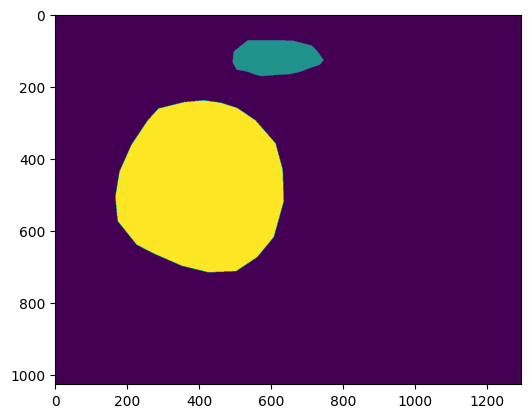

In [8]:
path = f'{dataset_path}/enhance_mask/{train_mask[1]}'
mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print(f'Shape = {mask.shape}, uniques value = {np.unique(mask.flatten())}')
plt.imshow(mask)
plt.show()

Shape = (1026, 1295, 3), uniques value = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 170 171 172 173 174 175 176 178 179 180 181 182 183 185 186
 187 188 189 190 192 193 194 195 196 197 199 200 201 202 203 204 206 207
 208 209 210 211 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 234 235 236 237 238 239 241 242 243 244 245 246
 248 249 2

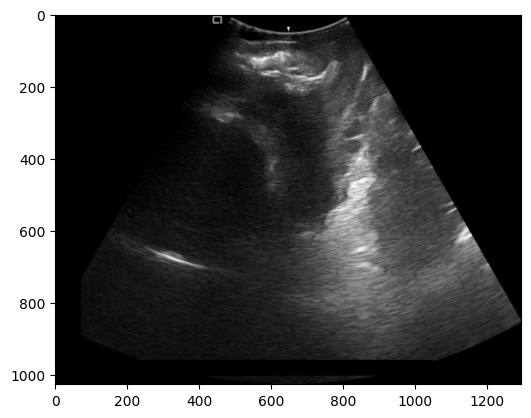

In [9]:
path = f'{dataset_path}/image/{train_img[1]}'
img = cv2.imread(path)
print(f'Shape = {img.shape}, uniques value = {np.unique(img.flatten())}')
plt.imshow(img)
plt.show()

#### Define dataset class

For maintaining the correct proportions when resizing or displaying the content
- we firstly center crop [1024, 12024]
- and then resize to [128, 128]
>> So the content doesn’t get distorted

**Notes**: For mask - need integer values for indexing or categorical representation -> 
Casts the elements of the tensor to the long data type, which is PyTorch's 64-bit integer type

In [10]:
# define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{dataset_path}/image/{img_name}'
        image = Image.open(img_path).convert('L')

        mask_name = self.masks[idx]
        mask_path = f'{dataset_path}/enhance_mask/{mask_name}'
        mask = Image.open(mask_path).convert('L') # read mask in grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # scale img and mask
#         scaled_mask = mask * 255  # scale to 255 (else long() -> 0)
#         long_mask = converted_mask.long()  # Convert mask to long tensor
        binary_mask= (mask > 0).long()
        converted_mask = binary_mask.squeeze() # removes redundant dimensions (1, rz, rz) > (rz, rz) 

        return image, converted_mask

#### Define dataset instance

In [11]:
t = T.Compose([
            T.CenterCrop((1024, 1024)),
            T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
    ])

train_set = SegmentationDataset(train_img, train_mask, transform=t)
val_set = SegmentationDataset(val_img, val_mask, transform=t)
test_set = SegmentationDataset(test_img, test_mask, transform=t)

img, mask = train_set[1]
print(f'{mask.shape}, {torch.unique(mask.flatten())}')

torch.Size([128, 128]), tensor([0, 1])


#### Instantiate dataloaders

In [12]:
train_loader = DataLoader(dataset=train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)

#### Test dataloaders

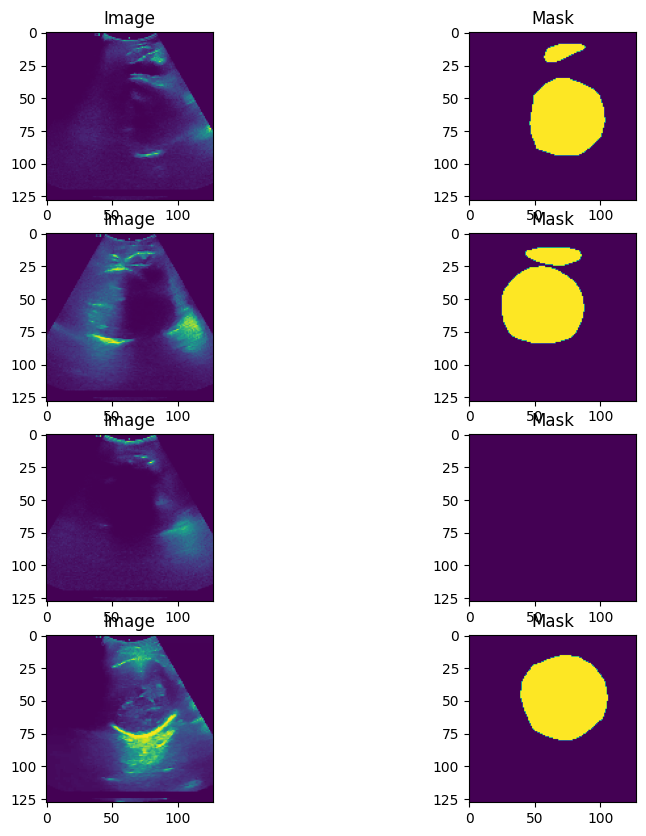

In [13]:
def visualize(loader, n=4):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))

    # Plot the images and masks in a grid
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 10))
    for i in range(n):
        axes[i, 0].imshow(images[i].permute(1, 2, 0)) # show the image
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(masks[i].squeeze()) # show the mask
        axes[i, 1].set_title("Mask")
    plt.show()

# Call the visualize function on the test dataloader
visualize(val_loader)

# Baseline model

In [14]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Encoder with downsampling layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Preserve spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Bottleneck layer for feature extraction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder with upsampling layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),  # Final output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        logits = self.decoder(x)
        
#         # Apply softmax along the second dimension (axis=1) to get probabilities
#         softmax_output = nn.functional.softmax(x, dim=1)

#         # Get the index of the maximum probability for each pixel
#         max_indices = torch.argmax(softmax_output, dim=1, keepdim=True)

#         # Map the indices to the specified values
#         mapped_output = torch.where(max_indices == 0, torch.tensor(0),
#                                      torch.where(max_indices == 1, torch.tensor(76),
#                                                  torch.tensor(150)))
        return logits

# Example usage
model = SegmentationModel(num_classes=2)

# Loss and optimizer

In [15]:
# Import the necessary modules
import torch
import torch.optim as optim

params = model.parameters() # get the model parameters

# Define the optimizer, such as Adam
optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Define the learning rate scheduler, such as StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training

Epoch 1/5:   0%|          | 0/630 [00:00<?, ?batch/s]

Epoch 1/5, Loss: 0.22228699191695167
Validation Loss: 0.22450651360882654


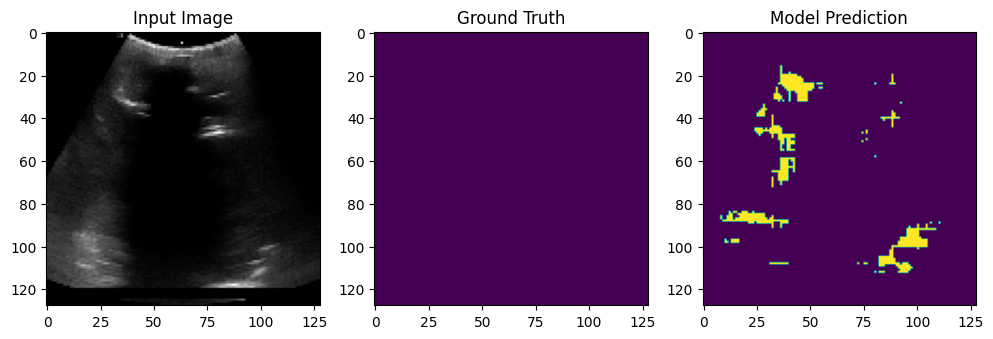

Epoch 2/5:   0%|          | 0/630 [00:00<?, ?batch/s]

Epoch 2/5, Loss: 0.1987311981381878
Validation Loss: 0.1874784011748575


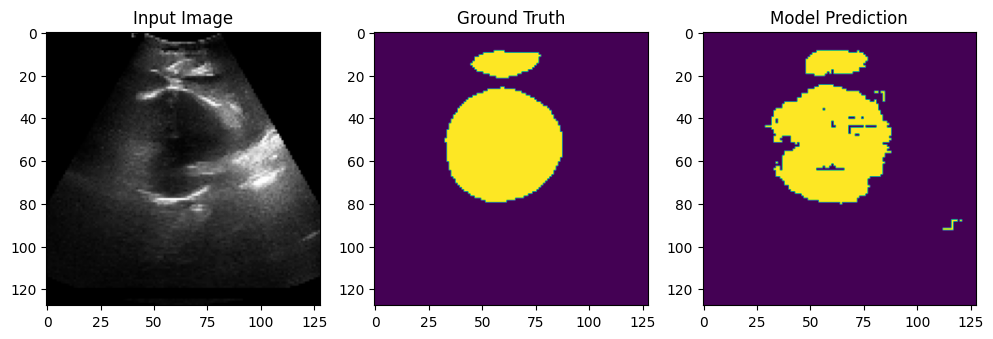

Epoch 3/5:   0%|          | 0/630 [00:00<?, ?batch/s]

Epoch 3/5, Loss: 0.18450304422350156
Validation Loss: 0.17472521394845986


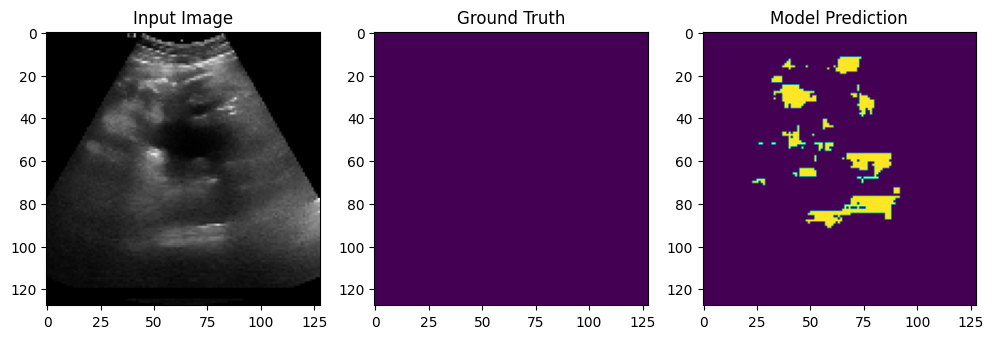

Epoch 4/5:   0%|          | 0/630 [00:00<?, ?batch/s]

Epoch 4/5, Loss: 0.17502851844543502
Validation Loss: 0.16922128805447192


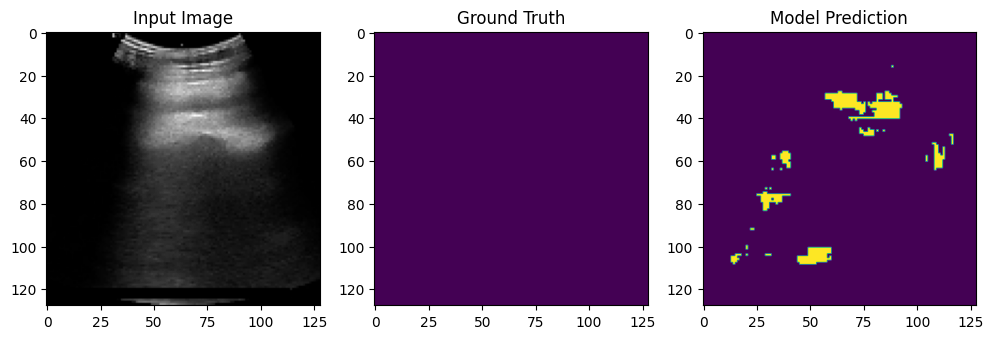

Epoch 5/5:   0%|          | 0/630 [00:00<?, ?batch/s]

Epoch 5/5, Loss: 0.1657767100939675
Validation Loss: 0.16354427685340245


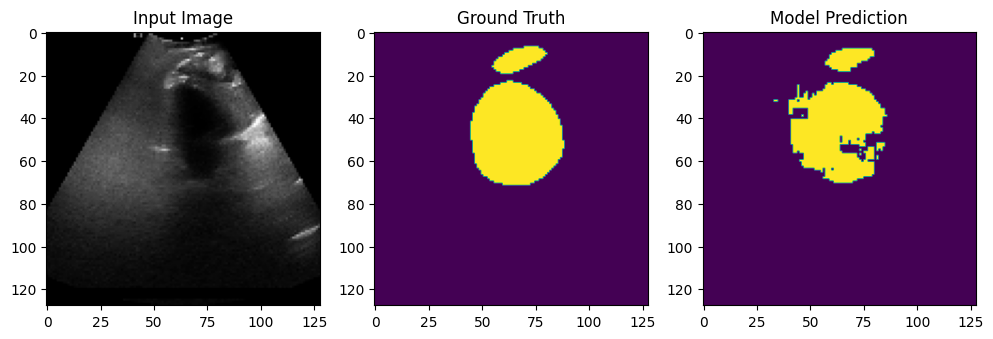

In [20]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix(loss=running_loss / (pbar.n + 1), refresh=True)
            pbar.update()

    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {average_val_loss}")

    # Visualization (optional)
    # Plot some example predictions during training
    model.eval()
    with torch.no_grad():
        example_inputs, example_labels = next(iter(val_loader))
        example_inputs, example_labels = example_inputs.to(device), example_labels.to(device)
        example_outputs = model(example_inputs)
        
        # Visualize input, ground truth, and prediction
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(example_inputs[0, 0].cpu().numpy(), cmap='gray')
        plt.title('Input Image')
        plt.subplot(1, 3, 2)
        plt.imshow(example_labels[0].cpu().numpy(), cmap='viridis')
        plt.title('Ground Truth')
        plt.subplot(1, 3, 3)
        plt.imshow(torch.argmax(example_outputs[0], dim=0).cpu().numpy(), cmap='viridis')
        plt.title('Model Prediction')
        plt.show()

# Testing

Test Loss: 0.16354427667730118


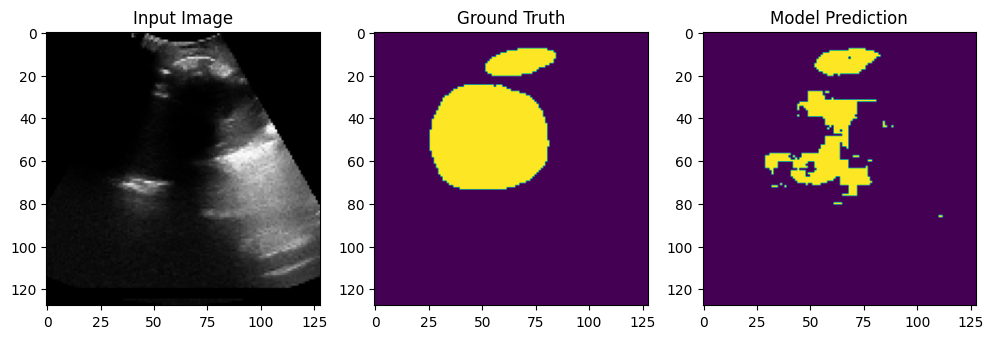

In [21]:
# Test
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {average_test_loss}")

model.eval()
with torch.no_grad():
    example_inputs, example_labels = next(iter(test_loader))
    example_inputs, example_labels = example_inputs.to(device), example_labels.to(device)
    example_outputs = model(example_inputs)

    # Visualize input, ground truth, and prediction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(example_inputs[0, 0].cpu().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(example_labels[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(torch.argmax(example_outputs[0], dim=0).cpu().numpy(), cmap='viridis')
    plt.title('Model Prediction')
    plt.show()